# IS318 - Machine Learning

## TP3 - SVM and bag of features

In this TP, we will experiment with SVM classifiers. We will also work with K-Means clustering. We will apply these methods to a classical image classification approach called **bag of features**.

In [17]:
import sklearn
import sklearn.cluster
import sklearn.datasets
import sklearn.model_selection
import skimage.feature
import skimage.io
from sklearn.svm import SVC

### 1. Introduction to SVM

In `scikit-learn` there exists several implementations of SVM. In this TP, we will use the `sklearn.svm.SVC` version, which allows to easily change the kernel used.

We will work a dataset of small images of faces called **Olivetti faces**. It is composed of 400 images of size 64x64, depicting 40 different persons.

In [18]:
olivetti_faces_dataset = sklearn.datasets.fetch_olivetti_faces()

**(Question)** Access the images and labels and set up an appropriate cross validation protocol.

*Hint*: take a look at the `sklearn.model_selection` module. 

In [19]:
# YOUR CODE HERE
from sklearn.model_selection import cross_val_score, train_test_split

X = olivetti_faces_dataset.data
y = olivetti_faces_dataset.target



print(X.shape, y.shape)

(400, 4096) (400,)


In [20]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(320, 4096) (320,)
(80, 4096) (80,)


**(Question)** Train a multi-class linear SVM classifier on this dataset with your cross-validation protocol. Report the classification accuracy on the validation/test set(s).

In [21]:
# YOUR CODE HERE
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1)

model.fit(X_train, y_train)

test_acc = model.score(X_test, y_test)

print("test accuracy : ", test_acc)

test accuracy :  0.975


In [22]:
cv_scores = cross_val_score(model, X_train, y_train, cv=4)


print("Cross-validation scores:", cv_scores)
print("Mean accuracy on cross-validation:", cv_scores.mean())

Cross-validation scores: [0.9375 0.9375 0.975  0.9875]
Mean accuracy on cross-validation: 0.9593750000000001


**(Question)** Experiment with different hyperparameters (notably the soft margin parameter $C$) and different kernels. Compare the results.

Text(0.5, 1.0, 'SVM Model Accuracies')

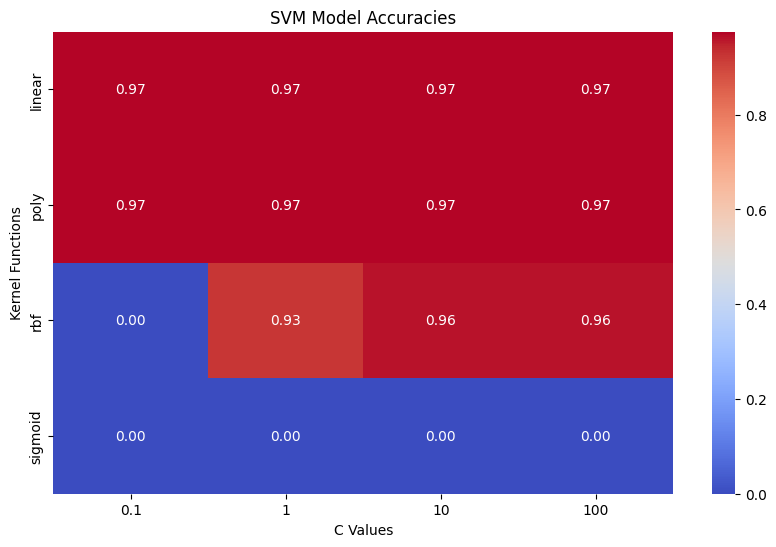

In [23]:
# YOUR CODE HERE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

c_values = [0.1, 1, 10, 100]

accs = np.zeros((len(kernels), len(c_values)))

for i in range(len(kernels)):
    for j in range(len(c_values)):
        model = SVC(kernel=kernels[i], C=c_values[j])
        model.fit(X_train, y_train)
        accs[i][j] = model.score(X_test, y_test)

plt.figure(figsize=(10, 6))
sns.heatmap(accs, annot=True, fmt='.2f', cmap='coolwarm', xticklabels=c_values, yticklabels=kernels)

plt.xlabel('C Values')
plt.ylabel('Kernel Functions')
plt.title('SVM Model Accuracies')

### 2. Scenes dataset

For the rest of the TP, to experiment with bag of features, we will work with the 8-scenes dataset originally from: https://people.csail.mit.edu/torralba/code/spatialenvelope/

It is provided as an archive file with this TP.

The function below can be used to load the dataset images and labels:

In [24]:
def load_scenes():
    '''Return images and labels of the scenes dataset.'''
    images = skimage.io.ImageCollection('scenes/*.jpg')
    labels_names = [f.split('/')[-1].split('_')[0] for f in images.files]
    unique_labels = sorted(list(set(labels_names)))
    labels_dict = {label: i + 1 for (i, label) in enumerate(unique_labels)}
    labels = np.array([labels_dict[label] for label in labels_names])
    return images, labels

**(Question)** Load the dataset and display some images of the different classes.

In [27]:
# YOUR CODE HERE
images, targets = load_scenes()

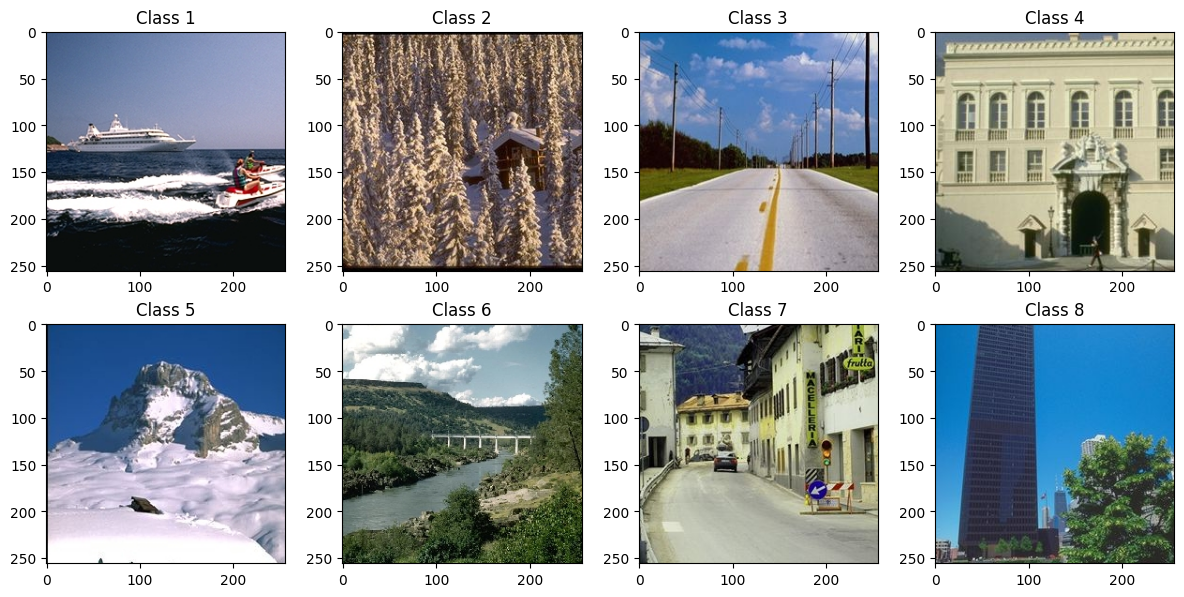

In [119]:
images_dict = {}

for image, target in zip(images,targets):
    if target not in images_dict:
        images_dict[target] = image

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, (target, image) in enumerate(images_dict.items()):
    row, col = divmod(i, 4)  
    axes[row, col].imshow(image)  
    axes[row, col].set_title(f"Class {target}")  

plt.tight_layout()  

### 3. HOG features

Instead of working directly with image pixels (which would represent almost 200k dimensional features), we will be using a very popular image feature descriptor called the Histogram of Oriented Gradients (HOG).

The principle of HOG is to compute a feature vector on several subregions of the image (called patches) for example of size 8x8. The image is then represented as a set of feature vectors corresponding to all patches.

The feature vectors computed are histograms of gradient orientations: the gradient of the image is computed (corresponding to its changes of intensity in each pixel), then the orientations of this gradient in each patch are accumulated into bins (here, we will be using 9 bins per patch).

In computer vision, HOG features are heavily related with the other well-known SIFT keypoints.

In [28]:
def hog_features(image):
    # Return a list of HOG features for a given image
    features = skimage.feature.hog(image, pixels_per_cell=(8, 8), cells_per_block=(1, 1),
                                   block_norm='L2-Hys', feature_vector=False, channel_axis=-1)
    features = features.reshape(-1, features.shape[-1])
    return features

**(Question)** Compute HOG features for a single image. Take a look at the feature vectors obtained and try to understand what the dimensions correspond to.

In [30]:
# YOUR CODE HERE
hog_feature = hog_features(images[0])

print(hog_feature.shape)

(1024, 9)


In [120]:
print(hog_feature[0])

[0.3663174  0.3663174  0.34293007 0.3663174  0.3663174  0.26435518
 0.3663174  0.3663174  0.08593406]


In [125]:
print((256 * 256) / (8 * 8)) #image shape / patch size;; 1024 region each one has its 9 bins histogram

1024.0


**(Question)** Compute HOG features for the whole dataset. If it takes too long, you can directly load them from the provided `hog.tgz` file.

In [76]:
# YOUR CODE HERE
dataset_features = np.array([hog_features(image) for image in images])

print(dataset_features.shape)

(2686, 1024, 9)


**(Question)** Split these features into train and test sets (for example 75% train, 25% test).

*Hint*: you can use the `train_test_split` method from `sklearn.model_selection`.

In [86]:
# YOUR CODE HERE
train_features, test_features, y_train, y_test = train_test_split(dataset_features, targets, test_size=0.25)

print(train_features.shape, test_features.shape)

(2014, 1024, 9) (672, 1024, 9)


### 4. Bag of features

We will now implement the bag of features approach. It is composed on three main steps:
- Learn a vocabulary of visual words (also called codebook) using a clustering method (for example K-Means) applied on HOG features
- Project each feature of an image into the vocabulary, and build an histogram of these projections, giving a final single feature vector for the image
- Train an SVM classifier with these histograms of visual words as features for training images

**(Question)** Build the vocabulary of visual words with K-Means. The vocabulary size corresponds to the number of clusters.

In [33]:
from sklearn.cluster import KMeans

In [79]:
def build_vocabulary(features, voc_size=100):
    # Cluster features into a visual vocabulary with K-Means algorithm,
    # then return the trained classified object.
    # You can use the MiniBatchKMeans class for very similar results 
    # but faster run time
    # YOUR CODE HERE
    kmeans = KMeans(voc_size, n_init='auto')
    for feature in features:
        kmeans.fit(feature)
    return kmeans

In [87]:
# Build the vocabulary from train features
# YOUR CODE HERE
vocabulary = build_vocabulary(train_features)

In [132]:
print(vocabulary.predict(train_features[0]).shape)

(1024,)


In [88]:
assert vocabulary.n_clusters == 100
assert vocabulary.n_features_in_ == 9

**(Question)** Try to understand the `build_codebook` function below. Then, compute the histograms of visual words for features of the train and test sets. Store the results into `X_train` and `X_test` variables.

In [91]:
def build_codebook(features, vocabulary):
    # Given a vocabulary of visual words (KMeans classifier object),
    # compute the codebook (histogram) of the set of features for an image
    voc_size = len(vocabulary.cluster_centers_)
    codebook = np.zeros((len(features), voc_size))
    for i, f in enumerate(features):
        assignemnts = vocabulary.predict(f)
        for k in range(voc_size):
            codebook[i][k] = len(np.where(assignemnts == k)[0])
    codebook = codebook / codebook.sum(axis=1)[:, np.newaxis] # normalization
    return codebook

In [92]:
# Build the codebooks for train and test features into X_train and X_test variables respectively
# YOUR CODE HERE
X_train = build_codebook(train_features, vocabulary)
X_test = build_codebook(test_features, vocabulary)

print(X_train.shape, X_test.shape)

(2014, 100) (672, 100)


In [93]:
assert X_train.shape == (y_train.shape[0], 100)
assert X_test.shape == (y_test.shape[0], 100)

**(Question)** Explain what the `build_codebook` function does.

The build_codebook function computes for each image a vector containing how many times each word in the vocabulary occur in the image based on the classifier of the features (called feature vector of the image).  

**(Question)** Train an SVM classifier with the histograms of visual words and report the classification results. Analyze the results and try to improve the classification results by adjusting the hyperparameters.

In [94]:
# YOUR CODE HERE
model = SVC(kernel='linear', C=5)
model.fit(X_train, y_train)

acc_score = model.score(X_test, y_test)
print(acc_score)

0.6681547619047619


In [107]:
from sklearn.model_selection import GridSearchCV


svm_model = SVC()

param_grid = {
    'C': [0.01,0.1,1,10,50,100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale','auto'],
}

grid_search = GridSearchCV(svm_model, param_grid, cv=4)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

acc = best_model.score(X_test, y_test)

print("Best Hyperparameters:", best_params)
print("Model Accuracy:", acc)

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Model Accuracy: 0.8035714285714286


**(Question)** Propose a visualization of some of the visual words learned by your bag of features model.